In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
import pickle
rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

#path stuff
from pathlib import WindowsPath, PosixPath
import sys
PathPath = WindowsPath if 'win' in sys.platform.lower() else PosixPath
PARENT_DIR = PathPath('../')
DATA_DIR = PARENT_DIR.joinpath('rf_data')
MODEL_PATH = PARENT_DIR.joinpath('.model')
INFERENCE_PATH = PARENT_DIR.joinpath('.inference')  
GIT_IMAGE_PATH = PARENT_DIR.joinpath('.git_images')
GIT_TABLE_PATH = PARENT_DIR.joinpath('.git_tables')
sys.path.append(str(PARENT_DIR))
from common_util import setup_axis_default
from matplotlib.lines import Line2D
from scipy.optimize import bisect
from functools import partial   
from jax import numpy as jnp
from jax import vmap
from typing import Callable, List, Tuple
from jax import random
from numpyro.distributions import TruncatedNormal   
from jaxopt import Bisection

SECONDS_TO_HOURS = 3600.0
HOURS_TO_YEAR = 24.0*365.0
SECONDS_TO_YEAR = SECONDS_TO_HOURS*HOURS_TO_YEAR


def get_temperature(time_function: Callable,
                    t: float,
                    T_bounds: Tuple = (873.15,2273.15)) -> np.ndarray:
    
    def _search_function(T: float) -> float:
        return time_function(T) - t

    return Bisection(_search_function,*T_bounds,check_bracket= False).run().params

def jmak_time_to_rx(a1:float,
                    a2: float,
                    B1: float, 
                    B2: float, 
                    n: float,
                    X: float, 
                    T: np.ndarray) -> np.ndarray:

    b = np.exp(a1 + B1/T)
    t_inc = np.exp(a2 + B2/T)
    return 1.0/b*np.log(1./(1. - X))**(1/n) + t_inc  

def sample_jmak_time_to_rx(
                    X: float, 
                    T: np.ndarray,
                    a1:float,
                    a2: float,
                    B1: float, 
                    B2: float, 
                    n: float,
                    sigma = None) -> np.ndarray:
    
    X = X if sigma is None else TruncatedNormal(X,sigma,low = 1e-3,high  =1 - 1e-3).sample(random.PRNGKey(B1.astype(int)))

    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)
    return 1.0/b*jnp.log(1./(1. - X))**(1/n) + t_inc  

def gl_to_to_rx(a1:float,
                a2: float,
                B1: float, 
                B2: float, 
                nu: float,
                X: float, 
                T: np.ndarray) -> np.ndarray:

    B = np.exp(a1 + B1/T)
    M = np.exp(a2 + B2/T)
    return M - 1/B*np.log(X**(-nu) - 1)

def sample_gl_time_to_rx(X: float, 
                    T: np.ndarray,
                    a1:float,
                    a2: float,
                    B1: float, 
                    B2: float, 
                    nu: float,
                    sigma = None) -> np.ndarray:
    
    X = X if sigma is None else TruncatedNormal(X,sigma,low = 1e-3,high  =1 - 1e-3).sample(random.PRNGKey(B1.astype(int)))

    B = jnp.exp(a1 + B1/T)
    M = jnp.exp(a2 + B2/T)
    return M - 1/B*jnp.log(X**(-nu) - 1)

def get_jmak_rx_temp(a1:float,
                   a2: float,
                   B1: float, 
                   B2: float, 
                   n: float,
                   X: float, 
                   t: np.ndarray,
                   T_range = (800,2000)) -> np.ndarray:

    _func = partial(jmak_time_to_rx, a1,a2,B1,B2,n,X)
    return bisect(lambda temp: _func(temp) -t, *T_range)

def get_gl_rx_temp(a1:float,
                     a2: float,
                     B1: float, 
                     B2: float, 
                     nu: float,
                     X: float, 
                     t: np.ndarray,
                     T_range = (800,2000)) -> np.ndarray:
    
     _func = partial(gl_to_to_rx, a1,a2,B1,B2,nu,X)
     return bisect(lambda temp: _func(temp) -t, *T_range)


def sample_rx_temperature(sample_model_time: Callable,
                            t: float,
                            T_bounds: jnp.ndarray,
                            X: float,
                            params_:List[jnp.ndarray]) -> jnp.ndarray:

    params = [jnp.array(param) for param in params_]
    
    def parameterized_function(*vparams) -> Callable:
        def temp_func(T: float) -> jnp.ndarray:
            return sample_model_time(X,T,*vparams)    
        
        return get_temperature(temp_func,t,T_bounds = T_bounds)
    
    return vmap(parameterized_function,
                in_axes= tuple([0]*len(params)))(*params)


c:\Users\micha\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


JMAK X = 0.1: 1088
JMAK X = 0.9: 1114
Generalized Logistic X = 0.1: 1090
Generalized Logistic X = 0.9: 1115
JMAK X = 0.1: 671
JMAK X = 0.9: 759
Generalized Logistic X = 0.1: 834
Generalized Logistic X = 0.9: 836


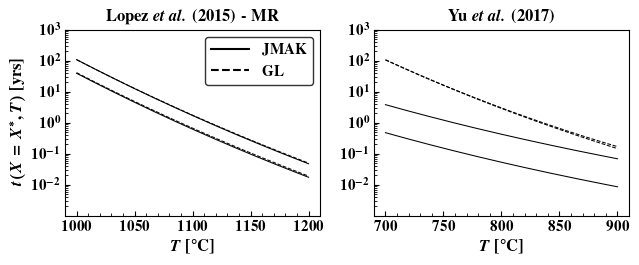

In [3]:
fig,axes = plt.subplots(ncols = 2,figsize = (6.5,2.75))
for ax in axes:
    setup_axis_default(ax)

T_lims = ([1000,1200],[700,900])
for ax,data_name,Tlim in zip(axes,['Lopez et al. (2015) - MR','Yu et al. (2017)'],T_lims):
    ax.set_xlabel(r'$T$ \textbf{[$^{\circ}$C]}',fontsize = 12)
    ax.set_ylabel(r'$t(X = X^*,T)$ \textbf{[yrs]}',fontsize = 12)
    ax.set_title(r'\textbf{' + data_name.replace('et al.',r'\textit{et al.}') + '}',fontsize = 12)

    temperature = np.linspace(*Tlim,1000) + 273.15
    for ttrx,rx_temp,model_name,ep_param,style in zip([jmak_time_to_rx,gl_to_to_rx],
                                                    [get_jmak_rx_temp,get_gl_rx_temp],
                                                    ['JMAK_{}','Generalized Logistic_{}'],
                                                    ['n','nu'],['-','--']):
        inf_summary = pd.read_csv(INFERENCE_PATH.joinpath(f'{model_name.format(data_name)}_trunc_normal_params.csv'),index_col = 0)
        for X in [0.1,0.9]:
            time = ttrx(*inf_summary.loc[['a1','a2','B1','B2',ep_param],'ml'].to_numpy(),X,temperature)
            ax.plot(temperature-273.15,time/SECONDS_TO_YEAR,color = 'k',
                    lw = 0.75,ls = style)
        
            temp = rx_temp(*inf_summary.loc[['a1','a2','B1','B2',ep_param],'ml'].to_numpy(),X,SECONDS_TO_YEAR)
            print(model_name.format('')[:-1] + f' X = {X}:',round(float(temp) - 273.13))
    
    ax.set_yscale('log')
    ax.set_ylim([1e-3,1e3])
    ax.set_yticks(np.logspace(-2,3,6))

legend = axes[0].legend(loc = 'upper right',fontsize = 11,
                   handles = [Line2D([0], [0], color='k', lw=1.5, label=r'\textbf{JMAK}'),
                              Line2D([0], [0], color='k', lw=1.5, ls='--', label=r'\textbf{GL}')],
                   handlelength = 2.5)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.0)


axes[1].set_ylabel('')
fig.tight_layout()
fig.savefig(GIT_IMAGE_PATH.joinpath('rx_temp_example.svg'),bbox_inches = 'tight')


### Get all Recrystallization Times


In [11]:
from numpyro.diagnostics import hpdi

def make_table(ml_df,low_df,high_df):

    text = '\\begin{table}[H]\n\\centering\n\\begin{tabular}{|c|c|c|}\n\\hline\n'
    text += 'Author & JMAK & GL \\\\\n\\hline\n'
    for author in ml_df.index:
        for model in ml_df.columns:
            text += str(round(ml_df.loc[author,model])) + \
                '(' + str(round(low_df.loc[author,model])) + ',' + \
                    str(round(high_df.loc[author,model])) + ')'
            text += '&'
        
        text = text[:-1] + '\\\\\n\\hline\n'    
    
    return text

authors = ['Lopez et al. (2015) - HR','Lopez et al. (2015) - MR',
           'Richou et al. (2020) - Batch A','Richou et al. (2020) - Batch B',
           'Yu et al. (2017)']


for X in [0.1,0.9]:
    ml_df = pd.DataFrame(np.empty([5,2]),index = authors,columns = ['JMAK','GL'])
    low_df = pd.DataFrame(np.empty([5,2]),index = authors,columns = ['JMAK','GL'])
    high_df = pd.DataFrame(np.empty([5,2]),index = authors,columns = ['JMAK','GL'])

    for author in authors:
        for ml_rx_temp,samp_rx_temp,model_name,ep_param,model in zip([get_jmak_rx_temp,get_gl_rx_temp],
                                                                     [sample_jmak_time_to_rx,sample_gl_time_to_rx],
                                                                     ['JMAK_{}','Generalized Logistic_{}'],
                                                                     ['n','nu'],
                                                                     ['JMAK','GL']):
            inf_summary = pd.read_csv(INFERENCE_PATH.joinpath(f'{model_name.format(author)}_trunc_normal_params.csv'),index_col = 0)

            with open(INFERENCE_PATH.joinpath(f'{model_name.format(author)}_trunc_normal_samples.pkl'),'rb') as f:
                posterior_samples = pickle.load(f)
            

            samples = [posterior_samples[p][::10] for p in ['a1','a2','B1','B2',ep_param,'sigma']]
            ml_temp = ml_rx_temp(*inf_summary.loc[['a1','a2','B1','B2',ep_param],'ml'].to_numpy(),X,SECONDS_TO_YEAR)
            sample_temp = sample_rx_temperature(samp_rx_temp,SECONDS_TO_YEAR,(100 + 273.15,3000 + 273.15),X,samples)
            
            #print(sample_temp)
            low,high = hpdi(sample_temp[:,jnp.newaxis],0.95)
            ml_df.loc[author,model] = ml_temp - 273.15
            low_df.loc[author,model] = low - 273.15
            high_df.loc[author,model] = high - 273.15

    table = make_table(ml_df,low_df,high_df)
    print(table)


\begin{table}[H]
\centering
\begin{tabular}{|c|c|c|}
\hline
Author & JMAK & GL \\
\hline
932(921,949)&974(945,984)\\
\hline
1088(1070,1098)&1090(1060,1100)\\
\hline
1076(1045,1111)&1088(1042,1114)\\
\hline
1033(971,1088)&1035(951,1102)\\
\hline
671(540,952)&834(549,3000)\\
\hline

\begin{table}[H]
\centering
\begin{tabular}{|c|c|c|}
\hline
Author & JMAK & GL \\
\hline
937(932,950)&976(949,985)\\
\hline
1114(1104,1117)&1115(1101,1129)\\
\hline
1118(1090,1147)&1126(1093,1152)\\
\hline
1072(1030,1108)&1074(1032,1110)\\
\hline
759(633,953)&836(585,930)\\
\hline

